In [127]:
# !pip install matplotlib # если запускаете в jupiter notebook

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [128]:
with open("metro.json", "r") as read_file:
    data = json.load(read_file)
# data['lines']

### Подготовка данных

In [129]:
class Station:
    def __init__(self, line_id, line_number, line_name, hexColor, 
                 station_id, order, station_name, lat, lng):
        self.line_id = line_id
        self.line_number = line_number
        self.line_name = line_name
        self.hexColor = hexColor
        
        self.id = station_id  # уникальный для каждой станции (во всем метро)
        self.order = order # порядок положения стации на линии
        self.name = station_name
        self.coords = [lat, lng] # широта и долгота станции

        # transits содержит id станций, до которых есть путь 
        # (по линии или пересадка) от этой станции без промежуточных
        # проверить на такое соседство две станции можно функцией

        self.transits = dict()
        self.drink = 0
    
    def add_transit(self, station_id, value):
        self.transits[station_id] = value

'''
Сокол Кофе Воробьева Арина Сергеевна
Маяковская Чай Олейников Иван Андреевич
Речной вокзал Кофе Макарова Анна Евгеньевна
Белорусская Чай Романадзе Екатерина Левановна
Речной вокзал Кофе Иванов Андрей Алексеевич
Беломорская Чай Еремеев Даниил Дмитриеви
Сходненская Кофе Лебедев Евгений
Пражская Чай Мирзагаламов Ринат Радикович
Юго-Западная Чай Мохов Алексей Игоревич
Калужская Кофе Чернева Надежда
Неизвестны: Абдулаев Артем, Девяткина Дария Владимировна, 
Кармазин Василий Вячеславович
'''

# Обозначим числами:
# чай: 1
# кофе: -1
# изначально у любой станции 0

drink_data = {'Сокол': -1, # один человек пьет кофе
          'Маяковская': 1, # один человек пьет чай
          'Речной вокзал': -2, # два человека пьют кофе
          'Белорусская': 1,
          'Беломорская': 1,
          'Сходненская': -1,
          'Пражская': 1,
          'Юго-Западная': 1,
          'Калужская': -1}
          
'''
get_neighbour_stations возвращает множество id соседних по ветке станций.
'''
def get_neighbour_stations(line, order):
    need_ids = set()
    for line_station in line['stations']:
        if line_station['order'] == order - 1 \
        or line_station['order'] == order + 1:
            need_ids.add(line_station['id'])
    return need_ids

'''
get_stations получает список элементов типа Station, в которых будет храниться
вся необходимая для нашей задачи инфа о станциях. То есть тут мы вытаскиваем
информацию из json, чтобы впоследствии больше не обращаться к нему.
'''
TRANSITION_LENGTH = 1 # длина перехода между соседними станциями между линиями
TRANSFER_LENGTH = 1 # длина переезда между станциями по линии

def get_stations(data):
    stations = []
    drink_stations_checked = []
    for line in data['lines']:
        for station in line['stations']:
            if not float(station['pos']['lat']) > 51.:
                name = station['title']
                new_station = Station(
                    line_id=line['id'], 
                    line_number=line['number'], 
                    line_name=line['title'],
                    hexColor=line['hexColor'],
                    station_id=station['id'],
                    order=station['order'],
                    station_name=name,
                    lat=float(station['pos']['lat']),
                    lng=float(station['pos']['lng']),
                    )
                if drink_data.get(name):
                    new_station.drink += drink_data[name]
                    drink_stations_checked.append(name)
                for s in get_neighbour_stations(line, station['order']):
                  new_station.add_transit(s, TRANSFER_LENGTH)
                for transfer in station['transferToStation']:
                    new_station.add_transit(transfer['id'], TRANSITION_LENGTH)
                stations.append(new_station)
    for _ in drink_data.keys():
        if not _ in drink_stations_checked:
            print(_, 'пропущена. Название станции в drink_data \
             не найдена в исходных данных')
    return np.array(stations)

'''
Индекс в массиве stations совпадает с id станций. Будет очень удобно, если 
совпадение будет.
Переопределим id станций. 
'''
def redefine_indices(stations):
    convertor = dict()
    for i, station in enumerate(stations):
        convertor[station.id] = i
        station.id = i
    for i, station in enumerate(stations): # в пересадках это тоже нужно учесть
        new_transits = dict()
        for key, value in station.transits.items():
            new_transits[convertor[key]] = value
        station.transits = new_transits
    return stations 

In [130]:
stations = get_stations(data)
stations = redefine_indices(stations)

for i, station in enumerate(stations):
    if not i == station.id:
        print('У станции "{}" id = {}, но индекс {}'. format(station.name, station.id, i))
else:
    print("Индекс любой станции совпадает с её id")

Индекс любой станции совпадает с её id


### Матрица смежности 
Представим метро в виде неориентированного графа G, где станции – вершины, а переезды по линии между ними или пересадки – ребра. 
Пусть матрица 
$ A = ||a_{ij}||$  – матрица смежности графа G. 
То есть ее элементы:

$$ a_{ij} = 
\begin{cases}
 0,\ если\ станции\ i\ и\ j\ не\ соседние \\
 1,\ если\ станции\ i\ и\ j\ соседние
\end{cases}
$$

Матрица $A^{m}$ обладает следующим свойством: элемент $ a_{ij}$ равен числу путей из i-й вершины в j-ю, состоящих из ровно m ребер. Это нам понадобится при поиске станций в окрестности.

In [131]:
'''
return_adj_matr возвращает матрицу смежности станций. 
'''
def return_adj_matr():
  ids = sorted([_.id for _ in stations])
  adjacency_matrix = pd.DataFrame(columns=ids, index=ids)
  adjacency_matrix = adjacency_matrix.fillna(0)
  for station in stations:
    for transit_id in station.transits:
        adjacency_matrix.loc[station.id][transit_id] = 1
  return adjacency_matrix

### Утилиты

In [132]:
'''
drink_stations_print отображает все пьющие станции
'''
def drink_stations_print():
    for _ in stations:
        if _.drink:
            print(_.name, _.drink)

'''
get_id возвращает id станции с именем name и line_id. 
обращается к значению line_id только если найдено больше одной
станции с заданным названием
'''
def get_id(station_name, line_id=None):
    suitable_stations = []
    for s in stations:
        if s.name == station_name:
            suitable_stations.append(s)
    if len(suitable_stations) == 0:
        print('Ошибка: станция "{}" не найдена'.format(station_name))
    elif len(suitable_stations) == 1:
        return suitable_stations[0].id
    else:
        print('Станция {} найдена на линиях {}'.format(station_name,
              ', '.join([s.line_name +' ('+str(s.line_id)+')' for s in suitable_stations])))
        if line_id is None:
            print('Возвращен id станции линии {}'.format(
                  str(suitable_stations[0].line_id)))
            return suitable_stations[0].id
        else:
            for s in suitable_stations:
                if s.line_id == line_id:
                    print('Возвращен id станции линии %s' % str(s.line_id))
                    return s.id
            else:
                print('Ошибка: задан невеный id линии')
                return None

def get_name(station_id):
    return stations[station_id].name

def get_station(id_or_name):
    for s in stations:
        if s.id == id_or_name or s.name == id_or_name:
            return s
    else:
        print('Ошибка: нет станции {}'.format(id_or_name))

'''
check_connection проверяет, являются ли две станции соседними (по линии или пересадке).
id1 и id2 могут быть как id станции, так и названия
'''
def check_connection(id1, id2, line_id1 = None, line_id2 = None):
    if type(id1) == str:
        id1 = get_id(id1, line_id1)
    if type(id2) == str:
        id2 = get_id(id2, line_id1)

    #### теоретически эти ошибки не должны вылезать
    error_string = 'Ошибка: id {} не соответствует индексу в массиве staions'
    assert stations[id1].id == id1, error_string.format(id1)
    assert stations[id2].id == id2, error_string.format(id2)
    #### но если их не перехватить, то можно будет сильно запутаться

    print(stations[id1].name + ' и ' + stations[id2].name, end=' – ')
    adj_matr = return_adj_matr()
    if adj_matr.loc[id1][id2]:
        print('соседние станции')
    else:
        print('не соседние станции')
  
'''
Графическое отображение всех станций по координатам
'''
def draw_map(stations):
    coords = np.empty((1, 2))
    for station in stations:
        coords = np.vstack((coords, station.coords))
    coords = np.delete(coords, 0, axis=0)

    plt.figure(figsize=(12, 12))
    for station in stations:
        x, y = station.coords
        plt.plot( y, x, 'o', color='#' + station.hexColor)
    plt.show()

In [133]:
# Проверка работы функции
get_id('Киевская', 4)
get_id('Парк культуры', 4)
get_id('Зорге', 4)
get_id('Зорге', 10)

Станция Киевская найдена на линиях Арбатско-Покровская линия (2), Филёвская линия (3), Кольцевая линия (4)
Возвращен id станции линии 4
Станция Парк культуры найдена на линиях Сокольническая линия (0), Кольцевая линия (4)
Возвращен id станции линии 4


268

In [134]:
# Шлифовка данных

# замкнем кольцевые линии
stations[get_id('Парк культуры', 4)].transits[get_id('Киевская', 4)] = 1
stations[get_id('Киевская', 4)].transits[get_id('Парк культуры', 4)] = 1

stations[get_id('Окружная', 15)].transits[get_id('Парк культуры', 4)] = 1
stations[get_id('Киевская', 4)].transits[get_id('Окружная', 15)] = 1

# у 14 линии цвет белый, который не видно. Исправим
for s in stations:
    if s.hexColor == 'FFFFFF':
        s.hexColor = 'FF506F'

Станция Парк культуры найдена на линиях Сокольническая линия (0), Кольцевая линия (4)
Возвращен id станции линии 4
Станция Киевская найдена на линиях Арбатско-Покровская линия (2), Филёвская линия (3), Кольцевая линия (4)
Возвращен id станции линии 4
Станция Киевская найдена на линиях Арбатско-Покровская линия (2), Филёвская линия (3), Кольцевая линия (4)
Возвращен id станции линии 4
Станция Парк культуры найдена на линиях Сокольническая линия (0), Кольцевая линия (4)
Возвращен id станции линии 4
Станция Окружная найдена на линиях Люблинско-Дмитровская линия (10), Московское центральное кольцо (15)
Возвращен id станции линии 15
Станция Парк культуры найдена на линиях Сокольническая линия (0), Кольцевая линия (4)
Возвращен id станции линии 4
Станция Киевская найдена на линиях Арбатско-Покровская линия (2), Филёвская линия (3), Кольцевая линия (4)
Возвращен id станции линии 4
Станция Окружная найдена на линиях Люблинско-Дмитровская линия (10), Московское центральное кольцо (15)
Возвращен

In [135]:
# пример работы функции check_connection
check_connection('Беломорская', 26)
check_connection(26, 27)
check_connection('Автозаводская', 'Электрозаводская')
check_connection('Театральная', 'Электрозаводская')
check_connection('Владыкино', 'Отрадное')

Беломорская и Ховрино – соседние станции
Ховрино и Беломорская – соседние станции
Станция Автозаводская найдена на линиях Замоскворецкая линия (1), Московское центральное кольцо (15)
Возвращен id станции линии 1
Автозаводская и Электрозаводская – не соседние станции
Театральная и Электрозаводская – не соседние станции
Станция Владыкино найдена на линиях Серпуховско-Тимирязевская линия (9), Московское центральное кольцо (15)
Возвращен id станции линии 9
Владыкино и Отрадное – соседние станции


In [136]:
adj_matr = return_adj_matr()
adj_matr

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
270,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
271,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
272,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1


### Алгоритм  

Алгоритм на вход принимает станцию, на выходе – 'чай' или 'кофе'.
target_station_id – id или название целевой станции
radius – радиус окрестности, в которой рассматрицаются станции. 
Алгоритм: 
1. смотрим целевую стацию. Если ее напиток извествен, то выдаем ответ. Если нет, то переходим к п. 2 
2. Смотрим по таблице смежности $A^{m}$ станции, до которых есть путь (то есть на первом шаге это все соседние станции), где m – который раз мы выполняем п.2. Добавляем полученные станции в отдельное множество.
3. выполняем п.2 еще r - 1 раз, где r – радиус окрестности рассматриваемых станций.
4. Суммируем напитки всех станций полученного множества (чай: 1, кофе: -1, ничего: 0). Если сумма равна 0, то повторяем п.2 и 4 еще раз.
5. Получаем ответ.

In [137]:
def model(target_station_id, line_id = None, radius = 2, testing_mode = False):
    data_to_return = dict()

    if type(target_station_id) == str:
        target_station_id = get_id(target_station_id, line_id)

    target_station = stations[target_station_id]
    data_to_return['target'] = target_station
    nearby_stations = {target_station.id: target_station.drink}
    summ_drink = sum(nearby_stations.values())
    adj_matr = return_adj_matr().values

    step = 1
    if summ_drink == 0:
        if testing_mode:
            print('    ', 'drink id  name')

    while summ_drink == 0 or step <= radius: 
        if testing_mode:
            print('Радиус поиска:', step)
        for s in np.array(stations)[np.where(adj_matr[target_station_id] >= 1)[0]]:
            if testing_mode:
                print('\t', s.drink, s.id, s.name)
            nearby_stations[s.id] = s.drink
        summ_drink = sum(nearby_stations.values())

        step += 1
        adj_matr = adj_matr @ adj_matr

    data_to_return['nearby'] = [stations[i] for i in nearby_stations.keys()]
    data_to_return['radius'] = radius

    if summ_drink > 0:
        data_to_return['answer'] = 'чай'
    elif summ_drink < 0:
        data_to_return['answer'] = 'кофе'
    
    return data_to_return

In [155]:
model_answer = model('Окружная', line_id=15, radius=2, testing_mode=False)
model_answer['answer']

Станция Окружная найдена на линиях Люблинско-Дмитровская линия (10), Московское центральное кольцо (15)
Возвращен id станции линии 15


'чай'

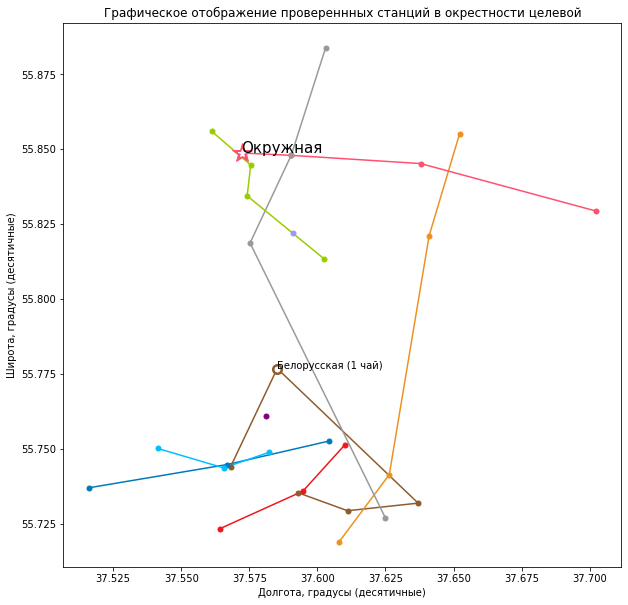

In [161]:
def rendering_the_response(model_answer):
    plt.figure(figsize=(10, 10))
    target = model_answer['target']
    line_ids = set([s.line_id for s in model_answer['nearby']])

    def drink_decoder(drink_code):
        if drink_code < 0:
            return str(abs(drink_code)) + ' кофе'
        elif drink_code > 0:
            return str(abs(drink_code)) + ' чай'

    lines_from_nearby = dict.fromkeys(line_ids, [])
    nearby_and_target_stations = model_answer['nearby'] + [model_answer['target']]
    for s in nearby_and_target_stations:
        lines_from_nearby[s.line_id] = lines_from_nearby[s.line_id] + [s]
    
    for line in lines_from_nearby.values():
        line = sorted(line, key=lambda x: x.order)
        
        x = [station.coords[0] for station in line]
        y = [station.coords[1] for station in line]
        plt.plot(x, y, '-', color='#' + line[0].hexColor, )

    for s in model_answer['nearby']:
        if not s.drink == 0:
            plt.plot(s.coords[0], s.coords[1], 'o',
                 ms=10, color='#'+s.hexColor)
            plt.plot(s.coords[0], s.coords[1], 'o',
                 ms=5, color='white')
            text = s.name + ' (' + drink_decoder(s.drink) + ')'
            plt.annotate(s=text, xy=(s.coords[0], s.coords[1]))
        else:
            plt.plot(s.coords[0], s.coords[1], 'o',
                 ms=5, color='#'+s.hexColor)

    plt.plot(target.coords[0], target.coords[1], 'o', 
             ms=20, color = '#' + target.hexColor, 
             marker='*')
    plt.plot(target.coords[0], target.coords[1], 'o', 
             ms=8, color = 'white', 
             marker='*')
    plt.annotate(s=target.name, xy=(target.coords[0], target.coords[1]), 
                 fontsize=15)

    plt.title('Графическое отображение провереннных станций в окрестности целевой')
    plt.xlabel('Долгота, градусы (десятичные)')
    plt.ylabel('Широта, градусы (десятичные)')

    plt.show()
rendering_the_response(model_answer)

In [159]:
print(model('Сокол')['answer'])
print(model('Речной вокзал')['answer'])
print(model('Беломорская')['answer'])
print(model('Белорусская')['answer'], end='\n\n')

кофе
кофе
кофе
Станция Белорусская найдена на линиях Замоскворецкая линия (1), Кольцевая линия (4)
Возвращен id станции линии 1
чай



In [160]:
print(model('Маяковская', radius=3)['answer'])
print(model('Окружная', radius=4)['answer'])
print(model('Окружная', radius=5)['answer'])
print(model('Окружная', radius=9)['answer'])

чай
Станция Окружная найдена на линиях Люблинско-Дмитровская линия (10), Московское центральное кольцо (15)
Возвращен id станции линии 10
чай
Станция Окружная найдена на линиях Люблинско-Дмитровская линия (10), Московское центральное кольцо (15)
Возвращен id станции линии 10
чай
Станция Окружная найдена на линиях Люблинско-Дмитровская линия (10), Московское центральное кольцо (15)
Возвращен id станции линии 10
чай
